##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core API 및 DTensor를 사용하는 분산 훈련

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/core/distribution"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 소개

이 노트북은 [TensorFlow Core 하위 수준 API](https://www.tensorflow.org/guide/core) 및 [DTensor](https://www.tensorflow.org/guide/dtensor_overview)를 사용하는 데이터 병렬 분산 훈련 예제를 보여줍니다. TensorFlow Core 및 기본 사용 사례에 대해 자세히 알아보려면 [Core API 개요](https://www.tensorflow.org/guide/core)를 확인하세요. DTensor에 대한 자세한 내용은 [DTensor 개요](https://www.tensorflow.org/guide/dtensor_overview) 가이드와 [DTensor를 사용하는 분산 훈련](https://www.tensorflow.org/tutorials/distribute/dtensor_ml_tutorial) 가이드를 참고하세요.

이 예제에서는 [멀티 레이어 퍼셉트론](https://www.tensorflow.org/guide/core/mlp_core) 가이드와 동일한 모델 및 최적화 도구를 사용합니다. Core API를 사용하는 엔드 투 엔드 머신러닝 워크플로를 작성하는 데 익숙해지려면 먼저 이 튜토리얼을 참고하세요.

참고: DTensor는 아직 실험적인 TensorFlow API입니다. 즉, 테스트에서 해당 기능을 사용할 수 있습니다. 사실 테스트 환경에서만 사용할 수 있습니다.

## DTensor를 사용하는 데이터 병렬 훈련 개요

분산 기능을 지원하는 MLP를 빌드하기 전에 잠시 시간을 내어 데이터 병렬 훈련용 DTensor의 기본 사항을 살펴보도록 합니다.

DTensor를 사용하여 장치 전반에서 분산 훈련을 실행하고 효율성과 안정성, 그리고 확장성을 개선할 수 있습니다. DTensor는 SPMD(Single program, multiple data) 확장이라는 절차와 샤딩 지시문에 따라 프로그램과 텐서를 배포합니다. `DTensor` 인식 레이어의 변수는 `dtensor.DVariable`로 생성되고, `DTensor` 인식 레이어 객체의 생성자는 일반적인 레이어 매개변수에 `Layout` 입력을 추가적으로 더합니다.

데이터 병렬 훈련의 주요 개념은 다음과 같습니다.

- 모델 변수는 각각 N개의 장치에 복제됩니다.
- 전역 배치는 복제본당 N개의 배치로 분할됩니다.
- 각 복제본의 배치는 복제본 장치에서 훈련됩니다.
- 모든 복제본에서 데이터 가중치 부여가 일괄적으로 수행되기 전에 그래디언트가 감소합니다.
- 데이터 병렬 훈련은 장치 수와 거의 비례하는 선형 속도를 제공합니다.

## 설치하기

DTensor는 TensorFlow 2.9.0 릴리스에 포함된 항목입니다.

In [2]:
#!pip install --quiet --upgrade --pre tensorflow

In [3]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.experimental import dtensor
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 21:44:41.543863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:44:41.543964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:44:41.543973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


이 실험을 위해 8개의 가상 CPU를 구성합니다. DTensor는 GPU 또는 TPU 장치와 함께 사용할 수도 있습니다. 이 노트북에서는 가상 장치를 사용하기 때문에 분산 훈련으로 인한 속도 향상은 눈에 띄지 않습니다. 

In [5]:
def configure_virtual_cpus(ncpu):
  phy_devices = tf.config.list_physical_devices('CPU')
  tf.config.set_logical_device_configuration(phy_devices[0], [
        tf.config.LogicalDeviceConfiguration(),
    ] * ncpu)

configure_virtual_cpus(8)

DEVICES = [f'CPU:{i}' for i in range(8)]
devices = tf.config.list_logical_devices('CPU')
device_names = [d.name for d in devices]
device_names

['/device:CPU:0',
 '/device:CPU:1',
 '/device:CPU:2',
 '/device:CPU:3',
 '/device:CPU:4',
 '/device:CPU:5',
 '/device:CPU:6',
 '/device:CPU:7']

## MNIST 데이터세트

[TensorFlow 데이터세트](https://www.tensorflow.org/datasets/catalog/mnist)의 데이터세트를 사용할 수 있습니다. 데이터는 훈련 세트와 테스트 세트로 나눕니다. 시간을 절약하기 위해 훈련과 테스트에 5000개의 예제만 사용합니다.

In [6]:
train_data, test_data = tfds.load("mnist", split=['train[:5000]', 'test[:5000]'], batch_size=128, as_supervised=True)

### 데이터 전처리하기

데이터를 2차원으로 변형하고 단위 간격 [0,1]에 맞도록 크기를 다시 조정하여 데이터를 전처리합니다.

In [7]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, test_data = train_data.map(preprocess), test_data.map(preprocess)

## MLP 빌드하기

DTensor 인식 레이어로 MLP 모델을 빌드합니다.

### 밀집 레이어

DTensor를 지원하는 밀집 레이어 모듈을 생성하는 것으로 시작합니다. `dtensor.call_with_layout` 함수는 DTensor 입력을 받고 DTensor 출력을 생성하는 함수를 호출하는 데 사용할 수 있습니다. 이것은 TensorFlow 지원 함수로 DTensor 변수 `dtensor.DVariable`을 초기화하는 데 유용합니다.

In [8]:
class DenseLayer(tf.Module):

  def __init__(self, in_dim, out_dim, weight_layout, activation=tf.identity):
    super().__init__()
    # Initialize dimensions and the activation function
    self.in_dim, self.out_dim = in_dim, out_dim
    self.activation = activation

    # Initialize the DTensor weights using the Xavier scheme
    uniform_initializer = tf.function(tf.random.stateless_uniform)
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(self.in_dim + self.out_dim, tf.float32))
    self.w = dtensor.DVariable(
      dtensor.call_with_layout(
          uniform_initializer, weight_layout,
          shape=(self.in_dim, self.out_dim), seed=(22, 23),
          minval=-xavier_lim, maxval=xavier_lim))
        
    # Initialize the bias with the zeros
    bias_layout = weight_layout.delete([0])
    self.b = dtensor.DVariable(
      dtensor.call_with_layout(tf.zeros, bias_layout, shape=[out_dim]))

  def __call__(self, x):
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

### MLP 순차 모델

이제 밀집 레이어를 순차적으로 실행하는 MLP 모듈을 생성합니다.

In [9]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

DTensor로 "데이터 병렬" 훈련을 수행하는 작업은 `tf.distribute.MirroredStrategy`와 동일합니다. 이를 위해 각 장치는 데이터 배치의 샤드에서 동일한 모델을 실행합니다. 따라서 다음이 필요합니다.

- 단일 `"batch"` 차원의 `dtensor.Mesh`
- 메시 전체에 가중치를 복제하는 모든 가중치용 `dtensor.Layout`(각 축에 `dtensor.UNSHARDED` 사용)
- 메시에서 배치 차원을 분할하는 데이터용 `dtensor.Layout`

단일 배치 차원으로 구성된 DTensor 메시를 생성합니다. 여기서 각 장치는 전역 배치에서 샤드를 수신하는 복제본이 됩니다. 이 메시를 사용하여 다음 아키텍처로 MLP 모드를 인스턴스화합니다.

순방향 전달: ReLU(784 x 700) x ReLU(700 x 500) x Softmax(500 x 10)


In [10]:
mesh = dtensor.create_mesh([("batch", 8)], devices=DEVICES)
weight_layout = dtensor.Layout([dtensor.UNSHARDED, dtensor.UNSHARDED], mesh)

input_size = 784
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_2_size = 10

mlp_model = MLP([
    DenseLayer(in_dim=input_size, out_dim=hidden_layer_1_size, 
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_1_size , out_dim=hidden_layer_2_size,
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_2_size, out_dim=hidden_layer_2_size, 
               weight_layout=weight_layout)])

### 훈련 메트릭

훈련에 교차 엔트로피 손실 함수와 정확성 메트릭을 사용합니다.

In [11]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(y_pred, axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### 옵티마이저

옵티마이저를 사용하면 표준 경사 하강법에 비해 훨씬 더 빠른 수렴 결과를 얻을 수 있습니다. Adam 옵티마이저가 아래에 구현되어 있으며DTensor와 호환되도록 구성되어 있습니다. Keras 옵티마이저를 DTensor와 함께 사용하려면 실험적 `tf.keras.dtensor.experimental.optimizers` 모듈을 참고합니다.

In [12]:
class Adam(tf.Module):

    def __init__(self, model_vars, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.model_vars = model_vars
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      # Initialize optimizer variable slots
      for var in model_vars:
        v = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        s = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        self.v_dvar.append(v)
        self.s_dvar.append(s)

    def apply_gradients(self, grads):
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, self.model_vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

### 데이터 패킹

장치에 데이터를 전송하는 헬퍼 함수를 작성하는 것으로 시작합니다. 이 함수는 `dtensor.pack`을 사용하여 복제본을 지원하는 장치로 복제본을 대상으로 하는 전역 배치의 샤드를 보내야(전송만 해야 함) 합니다. 편리한 진행을 위해 단일 클라이언트 애플리케이션을 가정합니다.

다음으로 이 헬퍼 함수를 사용하여 훈련 데이터 배치를 배치축(첫 번째)을 따라 샤딩한 DTensor로 패킹하는 함수를 작성합니다. 이렇게 하면 DTensor가 훈련 데이터를 '배치' 메시 차원에 고르게 분배합니다. DTensor에서 배치 크기는 항상 전역 배치 크기를 나타냅니다. 따라서 배치 크기는 배치 메시 차원의 크기로 균등하게 나눌 수 있도록 선택해야 합니다. `tf.data` 통합을 단순화하기 위한 추가 DTensor API가 계획되어 있으므로 계속 지켜봐 주시기 바랍니다.

In [13]:
def repack_local_tensor(x, layout):
  # Repacks a local Tensor-like to a DTensor with layout
  # This function assumes a single-client application
  x = tf.convert_to_tensor(x)
  sharded_dims = []

  # For every sharded dimension, use tf.split to split the along the dimension.
  # The result is a nested list of split-tensors in queue[0].
  queue = [x]
  for axis, dim in enumerate(layout.sharding_specs):
    if dim == dtensor.UNSHARDED:
      continue
    num_splits = layout.shape[axis]
    queue = tf.nest.map_structure(lambda x: tf.split(x, num_splits, axis=axis), queue)
    sharded_dims.append(dim)

  # Now we can build the list of component tensors by looking up the location in
  # the nested list of split-tensors created in queue[0].
  components = []
  for locations in layout.mesh.local_device_locations():
    t = queue[0]
    for dim in sharded_dims:
      split_index = locations[dim]  # Only valid on single-client mesh.
      t = t[split_index]
    components.append(t)

  return dtensor.pack(components, layout)

def repack_batch(x, y, mesh):
  # Pack training data batches into DTensors along the batch axis
  x = repack_local_tensor(x, layout=dtensor.Layout(['batch', dtensor.UNSHARDED], mesh))
  y = repack_local_tensor(y, layout=dtensor.Layout(['batch'], mesh))
  return x, y

### 훈련하기

데이터 배치를 제공할 경우 단일 훈련 단계를 실행하는 추적 가능한 함수를 작성합니다. 이 함수는 특별한 DTensor 주석을 요구하지 않습니다. 또한 테스트 단계를 실행하고 적절한 성능 메트릭을 반환하는 함수를 작성하도록 합니다.

In [14]:
@tf.function
def train_step(model, x_batch, y_batch, loss, metric, optimizer):
  # Execute a single training step
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  # Compute gradients and update the model's parameters
  grads = tape.gradient(batch_loss, model.trainable_variables)
  optimizer.apply_gradients(grads)
  # Return batch loss and accuracy
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

@tf.function
def test_step(model, x_batch, y_batch, loss, metric):
  # Execute a single testing step
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

이제 배치 크기가 128인 3 epoch의 MLP 모델을 훈련합니다.

In [15]:
# Initialize the training loop parameters and structures
epochs = 3
batch_size = 128
train_losses, test_losses = [], []
train_accs, test_accs = [], []
optimizer = Adam(mlp_model.trainable_variables)

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate through training data
  for x_batch, y_batch in train_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = train_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy, optimizer)
   # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate through testing data
  for x_batch, y_batch in test_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = test_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy)
    # Keep track of batch-level testing
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

# Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  print(f"Epoch: {epoch}")
  print(f"Training loss: {train_loss.numpy():.3f}, Training accuracy: {train_acc.numpy():.3f}")
  print(f"Testing loss: {test_loss.numpy():.3f}, Testing accuracy: {test_acc.numpy():.3f}")

Epoch: 0
Training loss: 1.850, Training accuracy: 0.343
Testing loss: 1.375, Testing accuracy: 0.504


Epoch: 1
Training loss: 1.028, Training accuracy: 0.674
Testing loss: 0.744, Testing accuracy: 0.782


Epoch: 2
Training loss: 0.578, Training accuracy: 0.839
Testing loss: 0.486, Testing accuracy: 0.869


### 성능 평가

먼저 훈련하는 동안 모델의 손실과 정확성을 시각화하는 플로팅 함수를 작성합니다. 

In [16]:
def plot_metrics(train_metric, test_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(test_metric)), test_metric, label = f"Testing {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training Epochs");

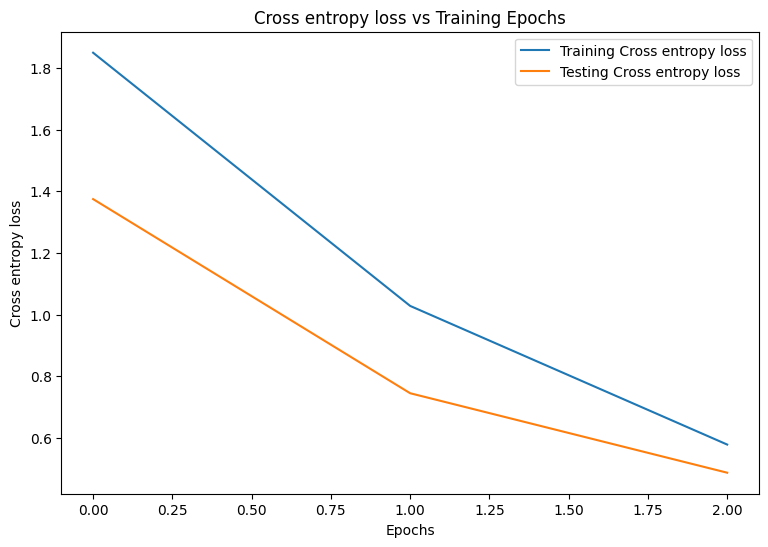

In [17]:
plot_metrics(train_losses, test_losses, "Cross entropy loss")

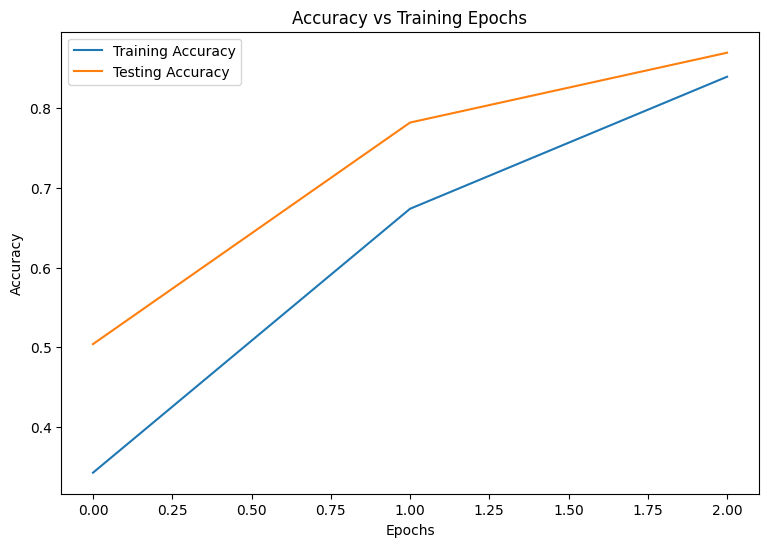

In [18]:
plot_metrics(train_accs, test_accs, "Accuracy")

## 모델 저장하기

`tf.saved_model`과 DTensor의 통합은 아직 개발을 진행하고 있습니다. TensorFlow 2.9.0부터 tf.saved_model은 완전히 복제된 변수가 있는 DTensor 모델만 허용합니다. 해결 방법으로 체크포인트를 다시 로드하여 DTensor 모델을 완전히 복제된 모델로 전환할 수 있습니다. 그러나 모델을 저장한 후에는 모든 DTensor 주석이 손실되며 저장된 서명은 일반 Tensor로만 사용할 수 있습니다. 안정화되면 통합을 보여주기 위해 이 튜토리얼이 업데이트됩니다.


## 결론

이 노트북에서는 DTensor 및 TensorFlow Core API를 사용하는 분산 훈련의 개요를 제공했습니다. 다음은 도움이 될 수 있는 몇 가지 추가 정보입니다.

- 분산 훈련을 지원하고 고도로 구성 가능한 머신러닝 워크플로를 구축하는 데 [TensorFlow Core API](https://www.tensorflow.org/guide/core)를 사용할 수 있습니다.
- [DTensor 개념](https://www.tensorflow.org/guide/dtensor_overview) 가이드 및 [DTensor를 사용하는 분산 훈련](https://www.tensorflow.org/tutorials/distribute/dtensor_ml_tutorial) 가이드에는 DTensor 및 통합에 대한 최신 정보가 포함되어 있습니다.

TensorFlow Core API를 사용하는 더 많은 예제는 [가이드](https://www.tensorflow.org/guide/core)를 확인하세요. 데이터 로드 및 준비에 대해 자세히 알아보려면 [이미지 데이터 로드](https://www.tensorflow.org/tutorials/load_data/images) 또는 [CSV 데이터 로드](https://www.tensorflow.org/tutorials/load_data/csv) 튜토리얼을 참고하세요.